In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from prophet import Prophet

from scipy.stats import boxcox
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
def correct_data(df):
    """
    Corrects the data by removing outliers and interpolating missing values.

    Parameters:
    - df: pandas DataFrame with at least two columns: 'timestamp' and 'load'.

    Returns:
    - df: corrected pandas DataFrame.
    """
    # Remove outliers
    df['load_diff'] = df['load'].diff(periods=1)
    outlier_idx = df['load_diff'].abs().idxmax()
    df.loc[outlier_idx-2:outlier_idx+2, 'load'] = None
    df['load'] = df['load'].interpolate(method='linear')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df.index = df.index.round('5min')
    df = df.asfreq('5min')
    df = df.interpolate()

    return df


def plot_actual_vs_forecast(actual_series, forecast_series, title="Actual vs Forecast", xlabel="Time", ylabel="Value"):
    """
    Plots the actual time series and forecast values on the same plot.

    Parameters:
        actual_series (pd.Series): Time-indexed series of actual values.
        forecast_series (pd.Series): Time-indexed series of forecasted values.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(actual_series, label='Actual', color='black')
    plt.plot(forecast_series, label='Forecast', color='red', linestyle=(0, (5, 5)), linewidth=2)
    plt.axvline(x=forecast_series.index[0], color='blue', linestyle='--', linewidth=1, label='Forecast Start')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def generate_time_series_kfold_datasets(df, n_splits=5, target_col='load'):
    """
    Returns train/test DataFrames for each fold in time series K-fold cross-validation.

    Parameters:
    - df: full time-ordered DataFrame
    - n_splits: number of folds
    - target_col: name of target column (optional, for clarity)

    Returns:
    - List of (train_df, test_df) tuples
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    datasets = []

    for train_idx, test_idx in tscv.split(df):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()
        datasets.append((train_df, test_df))

    return datasets

In [96]:
df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
df = correct_data(df)
df['load_diff'] = df['load'].diff(periods=1)
df = df.dropna(subset=['load_diff'])
df.drop(columns=['load_diff'], inplace=True)
df['load'], lambda_ = boxcox(df['load'])

In [97]:
n = len(df)
split_idx = int(n * 0.8)

train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

In [98]:
train_df = train.reset_index().rename(columns={'timestamp': 'ds', 'load': 'y'})
test_df = test.reset_index().rename(columns={'timestamp': 'ds', 'load': 'y'})

In [143]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    # seasonality_mode='multiplicative',
    # seasonality_prior_scale=20
)
model.add_seasonality(name='daily', period=1, fourier_order=100)
model.add_seasonality(name='hourly', period=1/24, fourier_order=100)
model.fit(train_df)

11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing


In [144]:
future = model.make_future_dataframe(periods=len(test_df), freq='5min')
forecast = model.predict(future)

In [145]:
forecast.set_index(forecast['ds'], inplace=True)
# forecast['yhat']

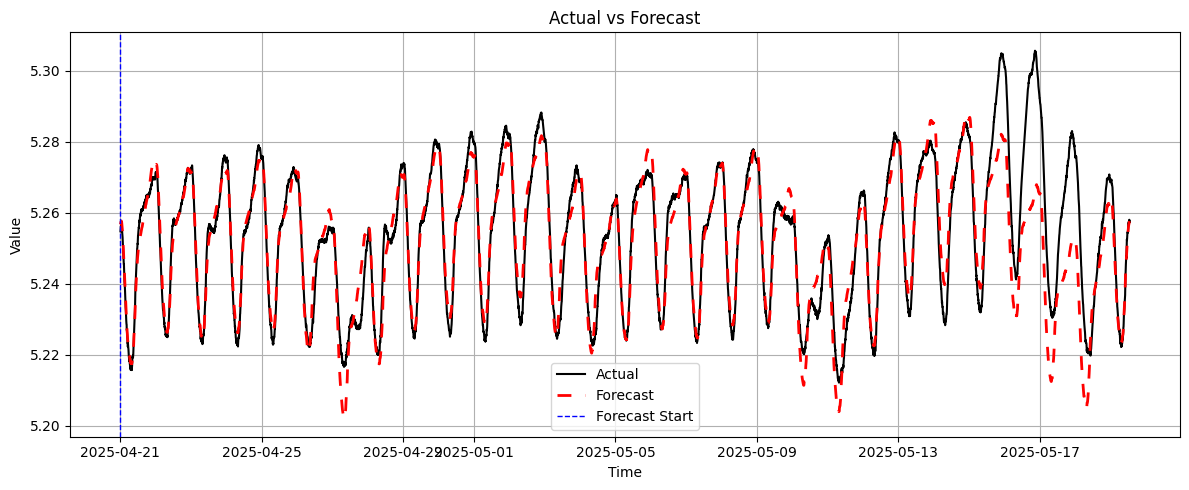

In [146]:
plot_actual_vs_forecast(df['load'], forecast['yhat'])

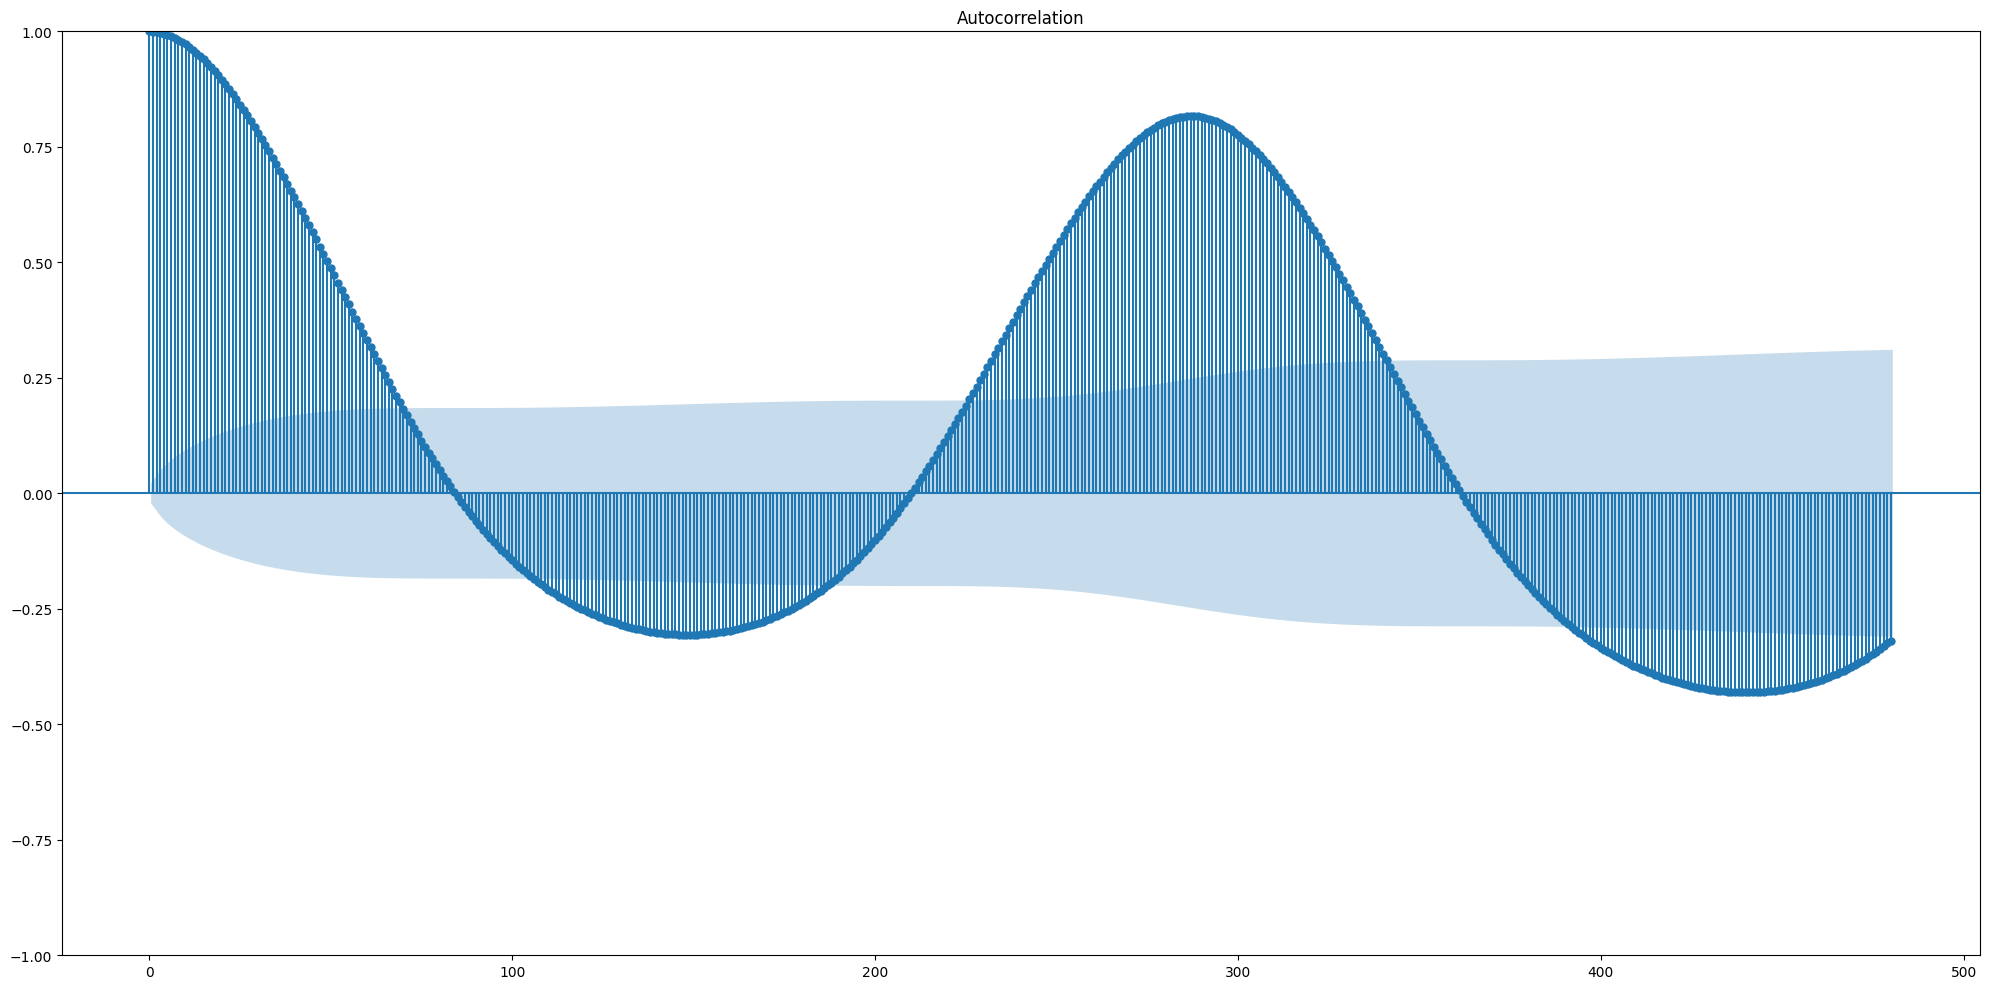

In [87]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(20, 10))  # Make it wider
plot_acf(df['load'], lags=24*20, ax=ax)
plt.tight_layout()
plt.show()